In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

In [12]:
np.random.seed(42)
n_users = 12000

df = pd.DataFrame({
    "user_id": range(1, n_users + 1),
    "group": np.random.choice(["control", "treatment"], size=n_users)
})

df["converted"] = np.where(
    df["group"] == "control",
    np.random.binomial(1, 0.07, n_users),
    np.random.binomial(1, 0.095, n_users)
)

df["revenue"] = np.where(
    df["converted"] == 1,
    np.random.gamma(shape=2.5, scale=40, size=n_users),
    0.0
)

df.head()

,user_id,group,converted,revenue
0,1,control,0,0.0
1,2,treatment,0,0.0
2,3,control,0,0.0
3,4,control,0,0.0
4,5,control,0,0.0


In [13]:
df.to_csv("marketing_ab_test_data.csv", index=False)

In [14]:
summary = df.groupby("group").agg(
    users=("user_id", "count"),
    conversions=("converted", "sum"),
    revenue=("revenue", "sum")
)

summary["conversion_rate"] = summary["conversions"] / summary["users"]
summary["revenue_per_user"] = summary["revenue"] / summary["users"]
summary

,users,conversions,revenue,conversion_rate,revenue_per_user
group,,,,,
control,6008,407,42495.523501,0.067743,7.073156
treatment,5992,562,56488.267745,0.093792,9.427281


In [19]:
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

control = summary.loc["control"]
treat = summary.loc["treatment"]

# Uplift
abs_lift = treat["conversion_rate"] - control["conversion_rate"]
rel_lift = abs_lift / control["conversion_rate"]
inc_conversions = abs_lift * control["users"]  # approx incremental conversions at same traffic

# Z-test (treatment vs control)
z_stat, p_value = proportions_ztest(
    [treat["conversions"], control["conversions"]],
    [treat["users"], control["users"]]
)

# 95% CI for (treatment - control)
low, high = confint_proportions_2indep(
    count1=treat["conversions"], nobs1=treat["users"],
    count2=control["conversions"], nobs2=control["users"],
    method="wald"
)

print(f"Control CR:   {control['conversion_rate']:.4%}")
print(f"Treatment CR: {treat['conversion_rate']:.4%}")
print(f"Absolute lift: {abs_lift:.4%}")
print(f"Relative lift: {rel_lift:.2%}")
print(f"~Incremental conversions (approx): {inc_conversions:.0f}")
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.6e}")  # prevents printing 0.0
print(f"95% CI (Treat - Control): [{low:.4%}, {high:.4%}]")

alpha = 0.05
if p_value < alpha and abs_lift > 0:
    print("Decision: Roll out treatment (significant uplift).")
else:
    print("Decision: Hold / rerun test (not significant).")

Control CR:   6.7743%
Treatment CR: 9.3792%
Absolute lift: 2.6049%
Relative lift: 38.45%
~Incremental conversions (approx): 157
Z-statistic: 5.237
P-value: 1.634653e-07
95% CI (Treat - Control): [1.6309%, 3.5789%]
Decision: Roll out treatment (significant uplift).


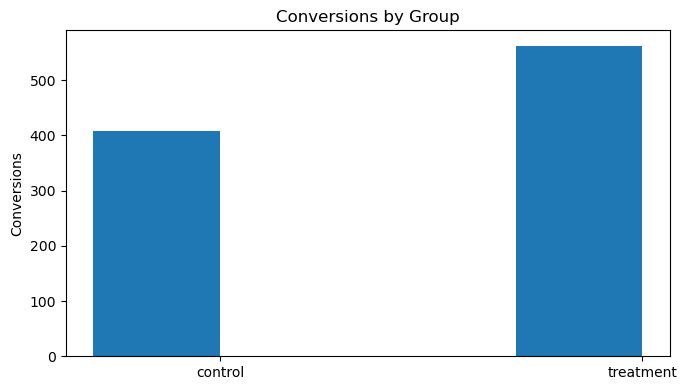

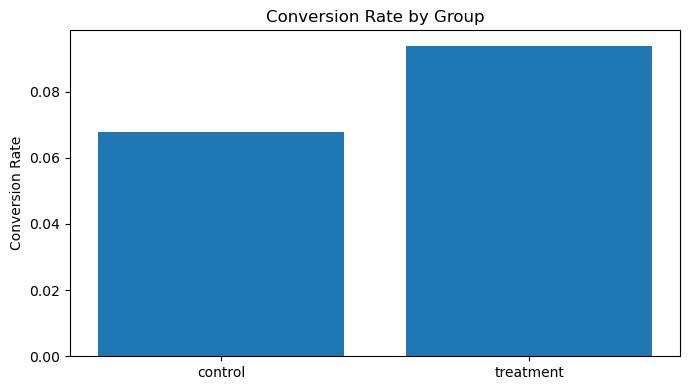

In [24]:
# Chart: conversions and conversion rate
plt.figure(figsize=(7,4))
x = np.arange(len(summary.index))

plt.bar(x - 0.15, summary["conversions"], width=0.3, label="Conversions")
plt.xticks(x, summary.index, rotation=0)
plt.ylabel("Conversions")
plt.title("Conversions by Group")
plt.tight_layout()
plt.savefig("conversions_by_group.png", dpi=200)
plt.show()

plt.figure(figsize=(7,4))
plt.bar(summary.index, summary["conversion_rate"])
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Group")
plt.tight_layout()
plt.savefig("conversion_rate_by_group.png", dpi=200)
plt.show()

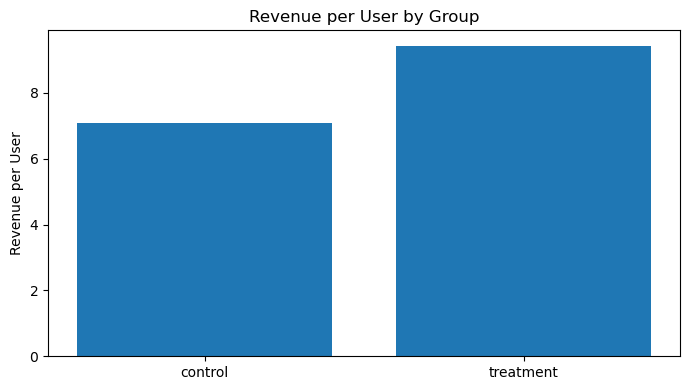

In [22]:
plt.figure(figsize=(7,4))
plt.bar(summary.index, summary["revenue_per_user"])
plt.ylabel("Revenue per User")
plt.title("Revenue per User by Group")
plt.tight_layout()
plt.savefig("revenue_per_user_by_group.png", dpi=200)
plt.show()

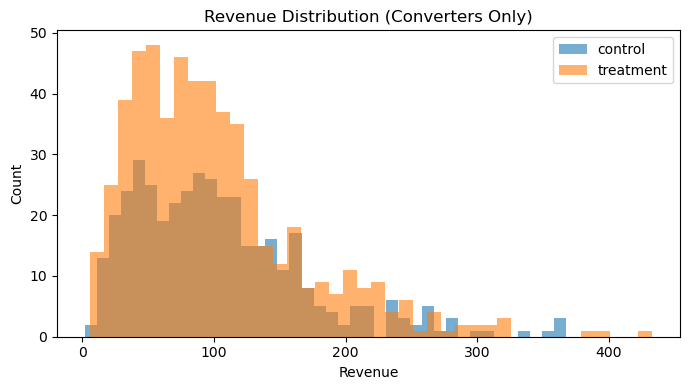

In [23]:
conv_only = df[df["converted"] == 1].copy()

plt.figure(figsize=(7,4))
for g in ["control", "treatment"]:
    vals = conv_only.loc[conv_only["group"] == g, "revenue"]
    plt.hist(vals, bins=40, alpha=0.6, label=g)

plt.title("Revenue Distribution (Converters Only)")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("revenue_distribution_converters.png", dpi=200)
plt.show()